In [1]:
!nvidia-smi

Fri Feb 12 16:42:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!git clone https://github.com/m3hrdadfi/zabanshenas
!cp -a zabanshenas/config /content/config/

In [6]:
!pip install -qU tokenizers
!pip install -qU clean-text[gpl]
!pip install -qU emoji

     |████████████████████████████████| 3.2MB 17.7MB/s 
     |████████████████████████████████| 133kB 23.4MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 245kB 57.6MB/s 


# Utils

In [2]:
import torch
import subprocess


def num_lines_in_file(fpath):
    return int(subprocess.check_output('wc -l %s' % fpath, shell=True).strip().split()[0])


def make_src_mask(
    input_ids: torch.Tensor,
    pad_idx: int = 0
):
    # input_ids shape: (batch_size, seq_len)
    # mask shape: (batch_size, 1, 1, seq_len)

    batch_size = input_ids.shape[0]

    src_mask = (input_ids != pad_idx).view(batch_size, 1, 1, -1)

    return src_mask


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Data

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from tokenizers import Tokenizer

In [4]:
tokenizer = Tokenizer.from_file("./config/tokenizer.json")

In [5]:
!rm ./wili-2018.zip
!wget https://zenodo.org/record/841984/files/wili-2018.zip

!mkdir -p ./wili-2018
!unzip wili-2018.zip -d wili-2018

--2021-02-12 16:42:30--  https://zenodo.org/record/841984/files/wili-2018.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62403646 (60M) [application/octet-stream]
Saving to: ‘wili-2018.zip’

wili-2018.zip       100%[===================>]  59.51M  17.1MB/s    in 3.5s    

2021-02-12 16:42:34 (17.1 MB/s) - ‘wili-2018.zip’ saved [62403646/62403646]

Archive:  wili-2018.zip
replace wili-2018/x_train.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace wili-2018/y_train.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace wili-2018/x_test.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace wili-2018/y_test.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace wili-2018/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace wili-2018/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace wili-2018/urls.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
labels = pd.read_csv("./wili-2018/labels.csv", sep=";")
labels["Label"] = labels["Label"].replace(np.nan, 'nan', regex=True)
languages = list(labels["Label"].unique())
print(f"Languages {len(languages)}")
labels.head()

Languages 235


,Label,English,Wiki Code,ISO 369-3,German,Language family,Writing system,Remarks,Synonyms
0,ace,Achinese,ace,ace,Achinesisch,Austronesian,NaN,NaN,NaN
1,afr,Afrikaans,af,afr,Afrikaans,Indo-European,NaN,NaN,NaN
2,als,Alemannic German,als,gsw,Alemannisch,Indo-European,NaN,(ursprünglich nur Elsässisch),NaN
3,amh,Amharic,am,amh,Amharisch,Afro-Asiatic,NaN,NaN,NaN
4,ang,Old English,ang,ang,Altenglisch,Indo-European,NaN,(ca. 450-1100),Angelsächsisch


In [7]:
# for mistaken labeling

labels[labels["Label"] == 'nan']

,Label,English,Wiki Code,ISO 369-3,German,Language family,Writing system,Remarks,Synonyms
142,nan,Min Nan Chinese,zh-min-nan,NaN,Min Nan,Sino-Tibetan,NaN,NaN,NaN


In [15]:
x_path = "./wili-2018/x_train.txt"
y_path = "./wili-2018/y_train.txt"

x1 = []
with open(x_path) as f:
    for line in tqdm(f, total=num_lines_in_file(x_path), position=0):
        line = line.strip().replace("\t", " ")
        if line:
            x1.append(line)


y1 = []
with open(y_path) as f:
    for line in tqdm(f, total=num_lines_in_file(y_path), position=0):
        line = line.strip().replace("\t", " ")
        if line:
            y1.append(line)

x1 = pd.DataFrame(x1, columns=["text"])
y1 = pd.DataFrame(y1, columns=["lang"])

df1 = pd.concat([x1, y1], axis=1)
print(df1.info())
df1.head()

100%|██████████| 117500/117500 [00:00<00:00, 1493259.00it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117500 entries, 0 to 117499
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    117500 non-null  object
 1   lang    117500 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB
None


,text,lang
0,Klement Gottwaldi surnukeha palsameeriti ning ...,est
1,"Sebes, Joseph; Pereira Thomas (1961) (på eng)....",swe
2,भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...,mai
3,"Après lo cort periòde d'establiment a Basilèa,...",oci
4,ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...,tha


In [16]:
x_path = "./wili-2018/x_test.txt"
y_path = "./wili-2018/y_test.txt"

x2 = []
with open(x_path) as f:
    for line in tqdm(f, total=num_lines_in_file(x_path), position=0):
        line = line.strip().replace("\t", " ")
        if line:
            x2.append(line)


y2 = []
with open(y_path) as f:
    for line in tqdm(f, total=num_lines_in_file(y_path), position=0):
        line = line.strip().replace("\t", " ")
        if line:
            y2.append(line)

x2 = pd.DataFrame(x2, columns=["text"])
y2 = pd.DataFrame(y2, columns=["lang"])

df2 = pd.concat([x2, y2], axis=1)
print(df2.info())
df2.head()

100%|██████████| 117500/117500 [00:00<00:00, 1308159.35it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117500 entries, 0 to 117499
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    117500 non-null  object
 1   lang    117500 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB
None


,text,lang
0,Ne l fin de l seclo XIX l Japon era inda çconh...,mwl
1,Schiedam is gelegen tussen Rotterdam en Vlaard...,nld
2,"ГIурусаз батальонал, гьоркьор гIарадабиги лъун...",ava
3,ರಾಜ್ಯಶಾಸ್ತ್ರದ ಪಿತಾಮಹೆ ಅರಿಸ್ಟಾಟಲ್. ರಾಜ್ಯಶಾಸ್ತ್ರ...,tcy
4,Halukum adalah kelenjar tiroid nang menonjol d...,bjn


In [17]:
df = pd.concat([df1, df2], axis=0)
print(df.info())

df = df.dropna()
print(df.info())

df["lang_id"] = df["lang"].apply(lambda t: languages.index(t) if t in languages else None)
df["tokens"] = df["text"].apply(lambda t: len(tokenizer.encode(t).ids))

df = df.dropna()
print(df.info())

df = df.drop_duplicates()
df = df.reset_index(drop=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235000 entries, 0 to 117499
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    235000 non-null  object
 1   lang    235000 non-null  object
dtypes: object(2)
memory usage: 5.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 235000 entries, 0 to 117499
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    235000 non-null  object
 1   lang    235000 non-null  object
dtypes: object(2)
memory usage: 5.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 235000 entries, 0 to 117499
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     235000 non-null  object
 1   lang     235000 non-null  object
 2   lang_id  235000 non-null  int64 
 3   tokens   235000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.0+ MB
None
<

,text,lang,lang_id,tokens
0,Klement Gottwaldi surnukeha palsameeriti ning ...,est,52,125
1,"Sebes, Joseph; Pereira Thomas (1961) (på eng)....",swe,198,82
2,भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...,mai,124,322
3,"Après lo cort periòde d'establiment a Basilèa,...",oci,155,401
4,ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...,tha,207,174


In [18]:
df[["tokens"]].describe()

,tokens
count,229095.000000
mean,165.281979
std,464.815900
min,29.000000
25%,75.000000
50%,116.000000
75%,190.000000
max,146683.000000


In [19]:
print(f'max_len 256, rate: {len(df[df["tokens"] <= 256]) / len(df)}')
print(f'max_len 512, rate: {len(df[df["tokens"] <= 512]) / len(df)}')

max_len 256, rate: 0.8574696086776228
max_len 512, rate: 0.9721076409349833


In [20]:
train, test = train_test_split(df, test_size=0.2, random_state=101, stratify=df["lang"])
train, valid = train_test_split(df, test_size=0.1, random_state=101, stratify=df["lang"])

print(train.shape)
print(valid.shape)
print(test.shape)

!rm -rf ./data
!mkdir -p ./data

train.to_json("./data/train.json")
valid.to_json("./data/valid.json")
test.to_json("./data/test.json")

(206185, 4)
(22910, 4)
(45819, 4)


In [21]:
ntrain = pd.read_json("./data/train.json")
ntrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206185 entries, 215013 to 110806
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     206185 non-null  object
 1   lang     206185 non-null  object
 2   lang_id  206185 non-null  int64 
 3   tokens   206185 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 7.9+ MB


In [22]:
nvalid = pd.read_json("./data/valid.json")
nvalid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22910 entries, 152571 to 184683
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     22910 non-null  object
 1   lang     22910 non-null  object
 2   lang_id  22910 non-null  int64 
 3   tokens   22910 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 894.9+ KB


In [23]:
ntest = pd.read_json("./data/test.json")
ntest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45819 entries, 8157 to 15087
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     45819 non-null  object
 1   lang     45819 non-null  object
 2   lang_id  45819 non-null  int64 
 3   tokens   45819 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.7+ MB


In [24]:
idx = np.random.randint(0, len(ntest))

sample_text = ntest.iloc[idx]["text"]
encoded = tokenizer.encode(sample_text.strip())

print(f"Tokens: {len(encoded.ids)}")
print(f"        Text: {sample_text}")
print(f"Decoded Text: {tokenizer.decode(encoded.ids)}")

Tokens: 71
        Text: Эволюция — акъыртын, секриусюз (революцияча болмай) тюрлениуледен къуралгъан айныу процессди. Эволюцияны юсюнден айтсакъ, кёбюсюне биологиялыкъ эволюцияны юсюнден айтабыз.
Decoded Text:  Эволюция — акъыртын, секриусюз (революцияча болмай) тюрлениуледен къуралгъан айныу процессди. Эволюцияны юсюнден айтсакъ, кёбюсюне биологиялыкъ эволюцияны юсюнден айтабыз.


In [25]:
print(f"There are {len(languages)} languages in this dataset")

There are 235 languages in this dataset


# Attentions

In [8]:
from typing import Optional
import torch
from torch import nn as nn


class ScaledDotProductAttention(nn.Module):
    """ Page 4, Chapter 3.2.1, Scaled Dot-Product Attention """

    def __init__(
        self,
        scaler: int,
        dropout_rate: float = 0.1
    ):
        super().__init__()
        self.scaler = scaler
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.Softmax(dim=-1)

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ):
        # attention shape: (batch_size, heads, seq_len, seq_len)
        # query shape: (batch_size, heads, seq_len, d_k)
        # key shape: (batch_size, heads, seq_len, d_k) -> (batch_size, heads, d_k, seq_len)
        # -> (batch_size, heads, seq_len, seq_len)
        attention = torch.matmul(query * self.scaler, key.transpose(-2, -1))

        if mask is not None:
            attention = attention.masked_fill(mask == torch.tensor(False), -1e7)

        attention = self.dropout(self.softmax(attention))

        # attention shape: (batch_size, heads, seq_len, seq_len)
        # value shape: (batch_size, heads, seq_len, d_v)
        # output shape: (batch_size, heads, seq_len, d_v)
        output = torch.matmul(attention, value)

        return output, attention


class MultiHeadAttention(nn.Module):
    """ Page 4-5, Chapter 3.2.2, Multi-Head Attention """

    def __init__(
        self,
        d_model: int,
        heads: int,
        keep_attention: bool = False,
        dropout_rate: int = 0.1
    ):
        super().__init__()

        assert d_model % heads == 0, "`d_model` needs to be divisible by `heads`"

        self.d_model = d_model
        self.heads = heads
        self.keep_attention = keep_attention

        d_k = d_v = d_model // heads
        self.d_k = d_k
        self.d_v = d_v
        self.scale = 1 / (d_k ** 0.5)

        self.W_Q = nn.Linear(d_model, heads * d_k)
        self.W_K = nn.Linear(d_model, heads * d_k)
        self.W_V = nn.Linear(d_model, heads * d_v)
        self.fc = nn.Linear(heads * d_v, d_model)

        self.attention = ScaledDotProductAttention(d_k ** 0.5)
        self.dropout = nn.Dropout(dropout_rate)
        self.norm = nn.LayerNorm(d_model)

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ):
        # query shape: (batch_size, seq_len, heads x d_k)
        # key shape: (batch_size, seq_len, heads x d_k)
        # value shape: (batch_size, seq_len, heads x d_v)

        batch_size = query.shape[0]
        residual = query

        # Attention projection
        # query shape: (batch_size, seq_len, heads x d_k) => (batch_size, seq_len, heads, d_k) => (batch_size, heads, seq_len, d_k)
        # key shape: (batch_size, seq_len, heads x d_k) => (batch_size, seq_len, heads, d_k) => (batch_size, heads, seq_len, d_k)
        # value shape: (batch_size, seq_len, heads x d_v) => (batch_size, seq_len, heads, d_k) => (batch_size, heads, seq_len, d_v)
        query = self.W_Q(query).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
        key = self.W_K(key).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
        value = self.W_V(value).view(batch_size, -1, self.heads, self.d_v).transpose(1, 2)

        x, attention = self.attention(query, key, value, mask=mask)

        # x (context) shape: (batch_size, heads, seq_len, d_v)
        # x reshape steps:
        # (batch_size, heads, seq_len, d_v) -> (batch_size, seq_len, heads, d_v)
        # (batch_size, seq_len, heads, d_v) -> (batch_size, seq_len, heads x d_v)
        x = x.transpose(1, 2).reshape(batch_size, -1, self.heads * self.d_v)
        x = self.dropout(self.fc(x))

        x = residual + x
        x = self.norm(x)

        if self.keep_attention:
            return x, attention.detach()

        return x


# Positionals

In [9]:
import numpy as np
import torch
from torch import nn as nn


class Embedding(nn.Module):
    """ Page 5, Chapter 3.4, Embeddings and Softmax """

    def __init__(
        self,
        n_vocab: int,
        d_model: int,
        pad_idx: int = 0,
        scale_wte: bool = False
    ):
        super().__init__()

        self.n_vocab = n_vocab
        self.d_model = d_model
        self.pad_idx = pad_idx
        self.scale_wte = scale_wte

        self.wte = nn.Embedding(n_vocab, d_model, padding_idx=pad_idx)

    def forward(
        self,
        input_ids: torch.Tensor,
    ):
        # input_ids shape: (batch_size, seq_len)

        embeddings = self.wte(input_ids)

        if self.scale_wte:
            embeddings = embeddings * (self.d_model ** 0.5)

        # embeddings shape: (batch_size, seq_len, d_model)
        return embeddings


class FixedPositionalEncoding(nn.Module):
    """ 
    Page 5-6, Chapter 3.5, Fixed Positional Encoding 
    Page 7, Chapter 5.4, Regularization
    """

    def __init__(
        self,
        d_model: int,
        n_position: int = 5000,
        dropout_rate: float = 0.1
    ):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.register_buffer(
            "positional_encoding",
            self._get_sinusoid_positional_encodeing(d_model, n_position)
        )

    def _get_sinusoid_positional_encodeing(
        self,
        d_model: int,
        n_position: int = 5000
    ):
        encodings = torch.zeros(n_position, d_model)
        position = torch.arange(0, n_position).unsqueeze(1)

        two_i = torch.arange(0, d_model, 2, dtype=torch.float)
        div_term = torch.exp(two_i * -(np.log(10000.0 / d_model)))

        encodings[:, 0::2] = torch.sin(position * div_term)  # 2i
        encodings[:, 1::2] = torch.cos(position * div_term)  # 2i+1

        # encodings = encodings.unsqueeze(1).requires_grad_(False)
        return encodings

    def forward(
        self,
        x: torch.Tensor
    ):
        # x shape: (batch_size, seq_len, d_model)
        # pe = self.positional_encoding[:x.shape[0]]
        pe = self.positional_encoding[:x.shape[1]]
        return self.dropout(x + pe)


class LearnedPositionalEncoding(nn.Module):
    """ 
    Page 5-6, Chapter 3.5, Fixed Positional Encoding 
    Page 7, Chapter 5.4, Regularization
    """

    def __init__(
        self,
        d_model: int,
        n_position: int = 5000,
        dropout_rate: float = 0.1
    ):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)

        # self.positional_encoding = nn.Parameter(torch.zeros(n_position, 1, d_model), requires_grad=True)
        self.positional_encoding = nn.Parameter(torch.zeros(n_position, d_model), requires_grad=True)

    def forward(
        self,
        x: torch.Tensor
    ):
        # x shape: (batch_size, seq_len, d_model)
        # pe = self.positional_encoding[:x.shape[0]]

        pe = self.positional_encoding[:x.shape[1]]
        return self.dropout(x + pe)


class PositionWiseFeedForward(nn.Module):
    """ Page 5, Chapter 3.3, Position-wise Feed-Forward Networks """

    def __init__(
        self,
        d_model: int,
        d_ff: int,
        dropout_rate: float = 0.1,
        activation=nn.ReLU(),
        bias1: bool = True,
        bias2: bool = True,
    ):
        super().__init__()

        self.L1 = nn.Linear(d_model, d_ff, bias=bias1)
        self.activation = activation
        self.L2 = nn.Linear(d_ff, d_model, bias=bias2)
        self.dropout = nn.Dropout(dropout_rate)
        self.norm = nn.LayerNorm(d_model)

    def forward(
        self,
        x: torch.Tensor
    ):
        # x shape: (batch_size, seq_len, d_model)
        residual = x

        L1 = self.L1(x)
        L1 = self.activation(L1)

        L2 = self.L2(L1)
        L2 = self.dropout(L2)

        x = residual + L2
        x = self.norm(x)

        return x


# Layers

In [10]:
import torch
from torch import nn as nn

# from attentions import MultiHeadAttention
# from positionals import PositionWiseFeedForward


class EncoderLayer(nn.Module):
    """ Page 3, Chapter 3.1, Figure 1, Encoder Layer """

    def __init__(
        self,
        d_model: int,
        attention: MultiHeadAttention,
        feed_forward: PositionWiseFeedForward,
        keep_attention: bool = False
    ):
        super().__init__()

        self.d_model = d_model
        self.keep_attention = keep_attention

        self.attention = attention
        self.feed_forward = feed_forward

    def forward(
        self,
        src: torch.Tensor,
        src_mask: torch.Tensor,
    ):
        # src, src_mask
        attention_list = None

        if self.keep_attention:
            x, attention_list = self.attention(
                query=src,
                key=src,
                value=src,
                mask=src_mask
            )

        else:
            x = self.attention(
                query=src,
                key=src,
                value=src,
                mask=src_mask
            )

        x = self.feed_forward(x)

        if self.keep_attention:
            return x, attention_list

        return x


class DecoderLayer(nn.Module):
    """ Page 3, Chapter 3.1, Figure 1, Decoder Layer """

    def __init__(
        self,
        d_model: int,
        attention: MultiHeadAttention,
        src_attention: MultiHeadAttention,
        feed_forward: PositionWiseFeedForward,
        keep_attention: bool = False
    ):
        super().__init__()

        self.d_model = d_model
        self.keep_attention = keep_attention

        self.attention = attention
        self.src_attention = src_attention
        self.feed_forward = feed_forward

    def forward(
        self,
        tgt: torch.Tensor,
        tgt_mask: torch.Tensor,
        src: torch.Tensor,
        src_mask: torch.Tensor
    ):
        # tgt, tgt_mask
        # src, src_mask

        attention_list = None
        src_attention_list = None

        if self.keep_attention:
            x, attention_list = self.tgt_attention(
                query=tgt,
                key=tgt,
                value=tgt,
                mask=tgt_mask
            )
        else:
            x = self.tgt_attention(
                query=tgt,
                key=tgt,
                value=tgt,
                mask=tgt_mask
            )

        if self.keep_attention:
            x, src_attention_list = self.src_attention(
                query=x,
                key=src,
                value=src,
                mask=src_mask
            )
        else:
            x = self.src_attention(
                query=x,
                key=src,
                value=src,
                mask=src_mask
            )

        x = self.feed_forward(x)

        if self.keep_attention:
            return x, [attention_list, src_attention_list]

        return x


# Models

In [153]:
from typing import Optional

import torch
from torch import nn as nn

# from attentions import MultiHeadAttention
# from layers import EncoderLayer
# from positionals import (
#     Embedding,
#     PositionWiseFeedForward,
#     FixedPositionalEncoding as PositionalEncoding
# )

import copy
import os

import numpy as np
from tqdm import tqdm
from tokenizers import Tokenizer

# from utils.utils import make_src_mask

PositionalEncoding = FixedPositionalEncoding

class Encoder(nn.Module):
    def __init__(
        self,
        d_model: int,
        heads: int,
        n_layers: int,
        ff_d_ff: int,
        ff_activation: nn.Module = nn.ReLU(),
        ff_bias1: bool = True,
        ff_bias2: bool = True,
        dropout_rate: float = 0.1,
        keep_attention: bool = False
    ):
        super().__init__()

        self.d_model = d_model
        self.heads = heads
        self.ff_d_ff = ff_d_ff
        self.n_layers = n_layers
        self.ff_activation = ff_activation
        self.ff_bias1 = ff_bias1
        self.ff_bias2 = ff_bias2
        self.keep_attention = keep_attention

        attention_layer = MultiHeadAttention(
            d_model=d_model,
            heads=heads,
            dropout_rate=dropout_rate,
            keep_attention=keep_attention
        )
        ff_layer = PositionWiseFeedForward(
            d_model=d_model,
            d_ff=ff_d_ff,
            dropout_rate=dropout_rate,
            activation=ff_activation,
            bias1=ff_bias1,
            bias2=ff_bias2,
        )
        encoder_layer = EncoderLayer(
            d_model=d_model,
            attention=attention_layer,
            feed_forward=ff_layer,
            keep_attention=keep_attention
        )
        self.layers = nn.ModuleList([
            copy.deepcopy(encoder_layer) for _ in range(n_layers)
        ])

        self.norm = nn.LayerNorm(d_model)

    def forward(
        self,
        src: torch.Tensor,
        src_mask: torch.Tensor
    ):
        # src shape: (batch_size, seq_len, d_model)
        # src_mask shape: (batch_size, 1, 1, seq_len)
        attention_list_layers = []

        x = src
        for layer in self.layers:
            if self.keep_attention:
                x, attention_list = layer(src=x, src_mask=src_mask)
                attention_list_layers.extend([attention_list])
            else:
                x = layer(src=x, src_mask=src_mask)

        x = self.norm(x)

        if self.keep_attention:
            return x, attention_list_layers

        return x


class TransformerLangDetection(nn.Module):

    def __init__(
        self,
        n_vocab: int,
        pad_idx: int,
        d_model: int,
        heads: int,
        ff_d_ff: int,
        n_layers: int,
        n_classes: int,
        n_position: int = 5000,
        ff_activation: nn.Module = nn.ReLU(),
        ff_bias1: bool = True,
        ff_bias2: bool = True,
        dropout_rate: float = 0.1,
        scale_wte: bool = False,
        keep_attention: bool = False
    ):
        super().__init__()

        self.keep_attention = keep_attention

        self.wte = Embedding(n_vocab, d_model, pad_idx=pad_idx, scale_wte=scale_wte)
        self.pe = PositionalEncoding(d_model, n_position, dropout_rate=dropout_rate)
        self.encoder = Encoder(
            d_model=d_model,
            heads=heads,
            n_layers=n_layers,
            ff_d_ff=ff_d_ff,
            ff_activation=ff_activation,
            ff_bias1=ff_bias1,
            ff_bias2=ff_bias2,
            dropout_rate=dropout_rate,
            keep_attention=keep_attention
        )
        self.classifer = nn.Linear(d_model, n_classes)

        self.model_args = {
            "n_vocab": n_vocab,
            "pad_idx": pad_idx,
            "d_model": d_model,
            "heads": heads,
            "ff_d_ff": ff_d_ff,
            "n_layers": n_layers,
            "n_classes": n_classes,
            "n_position": n_position,
            "ff_activation": ff_activation,
            "ff_bias1": ff_bias1,
            "ff_bias2": ff_bias2,
            "dropout_rate": dropout_rate,
            "scale_wte": scale_wte,
            "keep_attention": keep_attention,
        }

    def forward(
        self,
        input_ids: torch.Tensor,
        input_mask: torch.Tensor,
    ):
        attention_list_layers = []

        embedding = self.wte(input_ids)
        pe = self.pe(embedding)

        if self.keep_attention:
            encoded, attention_list_layers = self.encoder(pe, input_mask)
        else:
            encoded = self.encoder(pe, input_mask)

        mean_encoded = torch.mean(encoded, dim=1)
        logits = self.classifer(mean_encoded)

        if self.keep_attention:
            return logits, attention_list_layers

        return logits

    @staticmethod
    def load_tokenizer(
        tokenizer_file: str,
        enable_padding: bool = True,
        pad_token: str = "<pad>",
        max_seq_len: int = 512
    ):
        assert os.path.exists(tokenizer_file), "tokenizer_file does not exists"
        tokenizer = Tokenizer.from_file(tokenizer_file)

        if enable_padding:
            tokenizer.enable_padding(
                direction="right",
                pad_id=tokenizer.encode(pad_token).ids[0],
                pad_type_id=0,
                pad_token=pad_token,
                length=max_seq_len,
                pad_to_multiple_of=None
            )

            tokenizer.enable_truncation(
                max_seq_len,
                stride=0,
                strategy='longest_first'
            )

        return tokenizer

    def save(
        self,
        model_dir: str,
    ):
        os.makedirs(model_dir, exist_ok=True)
        torch.save(self.state_dict(), os.path.join(model_dir, "model.bin"))
        torch.save(self.model_args, os.path.join(model_dir, "model_args.bin"))

    @staticmethod
    def load(
        model_dir: str,
        model_args: dict = {}
    ):
        assert os.path.exists(model_dir), "model_dir does not exists"

        try:
            model_args_default = torch.load(os.path.join(model_dir, "model_args.bin"))
            model_args_default.update(model_args)

            model = TransformerLangDetection(**model_args_default)
            model.load_state_dict(torch.load(os.path.join(model_dir, "model.bin")))
        except:
            model = None

        return model

    def predict(
        self,
        x: list,
        tokenizer: Tokenizer,
        label_map: dict = {},
        batch_size: int = 32,
        progressbar: bool = True,
        keep_attention: bool = False,
        pad_token: str = "<pad>",
        topk: int = 5,
        device: Optional[torch.device] = None
    ):
        if not device:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        n_x = len(x)
        n_batches = int(np.ceil(n_x / batch_size)) if n_x > batch_size else 1
        has_label_map = True if isinstance(label_map, dict) and len(label_map) > 0 else False

        ids_predictions = []
        names_predictions = []
        attention_list = None
        input_tokens_list = []

        y_preds = []
        y_names = []
        y_probs = []

        topk_preds = []
        topk_probs = []
        
        model = self
        model = model.to(device)

        keep_attention = True if model.keep_attention or keep_attention else False

        for i in tqdm(range(n_batches), disable=not progressbar, position=0):
            batch = x[i * batch_size: (i + 1) * batch_size]

            input_ids = torch.tensor([tokenizer.encode(text).ids for text in batch], dtype=torch.long)
            input_masks = make_src_mask(input_ids)

            input_ids = input_ids.to(device)
            input_masks = input_masks.to(device)

            if keep_attention:
                input_tokens = [[tokenizer.decode([token_id]) for token_id in tokenizer.encode(
                    text).ids if token_id != tokenizer.encode(pad_token).ids[0]] for text in batch]
                input_tokens_list.extend(input_tokens)

            model.eval()
            with torch.no_grad():

                if keep_attention:
                    outputs, _attention_list = model(input_ids, input_masks)
                    attention_list = [attention.detach().cpu().numpy() for attention in _attention_list]
                else:
                    outputs = model(input_ids, input_masks)

                probs, preds = torch.topk(outputs, k=topk)
                
                probs = probs.detach().cpu().numpy()
                preds = preds.detach().cpu().numpy()

                y_probs.extend(probs[:, 0].tolist())
                y_preds.extend(preds[:, 0].tolist())

                topk_probs.extend(probs.tolist())
                topk_preds.extend(preds.tolist())

                if has_label_map:
                    y_names.extend([label_map.get(pred, None) for pred in preds[:, 0].tolist()])

        y_probs = np.array(y_probs)
        y_preds = np.array(y_preds)

        topk_probs = np.array(topk_probs)
        topk_preds = np.array(topk_preds)

        if keep_attention:

            if has_label_map:
                return [y_probs, y_preds, y_names], [topk_probs, topk_preds], attention_list, input_tokens_list
            else:
                return [y_probs, y_preds], [topk_probs, topk_preds], attention_list, input_tokens_list

        print("has_label_map", has_label_map)
        if has_label_map:
            return [y_probs, y_preds, y_names], [topk_probs, topk_preds]

        return [y_probs, y_preds], [topk_probs, topk_preds]


# Data Loader

In [12]:
import torch
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
from tokenizers import Tokenizer
import os


class LangDataset(Dataset):
    def __init__(
        self,
        json_file: str,
        tokenizer: Tokenizer,
        x_label: str,
        y_label: str,
        max_data: int = 0
    ):
        super().__init__()

        assert os.path.exists(json_file), "json_file does not exists"

        self.tokenizer = tokenizer
        
        df = pd.read_json(json_file)
        if max_data > 0:
            df = df.sample(n=max_data)
            

        self.x = df[x_label].values if x_label and x_label in list(df.columns) else None
        self.has_y = False
        self.y = None
        self.labels = None

        if y_label and y_label in list(df.columns):
            self.has_y = True
            self.y = df[y_label].values

    def __len__(self):
        return len(self.x)

    def __getitem__(
        self,
        idx
    ):
        output = {}

        x = self.x[idx]
        output["input_texts"] = x
        output["input_ids"] = torch.tensor(self.tokenizer.encode(x).ids, dtype=torch.long)

        if self.has_y:
            y = self.y[idx]
            output["targets"] = torch.tensor(y, dtype=torch.long)

        return output

# Training

In [13]:
import torch
from torch import nn as nn
from torch.utils.data import Dataset, DataLoader

from tokenizers import Tokenizer

import numpy as np
from tqdm import tqdm

import time
import os
import shutil
import glob


# from models import TransformerLangDetection
# from data_loader import LangDataset
# from utils.utils import (
#     count_parameters,
#     make_src_mask
# )


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def main(data_args, model_args, training_args):
    print(f"DataTrainingArguments: \n{data_args.to_json()}")
    print(f"ModelArguments: \n{model_args.to_json()}")
    print(f"TrainingArguments: \n{training_args.to_json()}")

    print("Creating tokenizer ...")
    assert os.path.exists(data_args.tokenizer_file), "tokenizer_file does not exists"

    tokenizer = Tokenizer.from_file(data_args.tokenizer_file)
    if data_args.enable_padding:
        tokenizer.enable_padding(
            direction="right",
            pad_id=tokenizer.encode(data_args.pad_token).ids[0],
            pad_type_id=0,
            pad_token=data_args.pad_token,
            length=data_args.max_seq_len,
            pad_to_multiple_of=None
        )

        tokenizer.enable_truncation(
            data_args.max_seq_len,
            stride=0,
            strategy='longest_first'
        )

    print("Creating dataset ...")
    train_dataset = LangDataset(
        data_args.train_file,
        tokenizer,
        x_label=data_args.x_label,
        y_label=data_args.y_label,
        max_data=data_args.max_data
    )
    valid_dataset = LangDataset(
        data_args.valid_file,
        tokenizer,
        x_label=data_args.x_label,
        y_label=data_args.y_label,
        max_data=data_args.max_data
    )

    print(
        f"Train dataset sample:\n"
        f"input_texts: {train_dataset[0]['input_texts'][:100]} ...\n"
        f"  input_ids: {train_dataset[0]['input_ids'][:100]}\n"
        f"    targets: {train_dataset[0]['targets']}\n"
    )
    print(
        f"Validation dataset sample:\n"
        f"input_texts: {train_dataset[0]['input_texts'][:100]} ...\n"
        f"  input_ids: {train_dataset[0]['input_ids'][:100]}\n"
        f"    targets: {train_dataset[0]['targets']}\n"
    )

    print("Creating dataloader ...")
    train_loader = DataLoader(train_dataset, batch_size=data_args.train_batch_size, shuffle=data_args.train_shuffle)
    valid_loader = DataLoader(valid_dataset, batch_size=data_args.valid_batch_size, shuffle=data_args.valid_shuffle)

    print(f"Train dataloader shape: {next(iter(train_loader))['input_ids'].shape}")
    print(f"Validation dataloader shape: {next(iter(valid_loader))['input_ids'].shape}")

    print("Creating model ...")
    model = TransformerLangDetection(
        n_vocab=len(tokenizer.get_vocab()),
        pad_idx=tokenizer.encode(data_args.pad_token).ids[0],
        d_model=model_args.d_model,
        heads=model_args.heads,
        n_position=model_args.n_position,
        ff_d_ff=model_args.ff_d_ff,
        ff_activation=model_args.ff_activation,
        ff_bias1=model_args.ff_bias1,
        ff_bias2=model_args.ff_bias2,
        n_layers=model_args.n_layers,
        n_classes=model_args.n_classes,
        dropout_rate=model_args.dropout_rate,
        scale_wte=model_args.scale_wte,
        keep_attention=model_args.keep_attention
    ).to(device)
    print()
    print(f"Model has {count_parameters(model):,} parameters")
    print()

    criterion = nn.CrossEntropyLoss()
    lr = training_args.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.95, 0.99))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    def train(epoch, steps=0):
        model.train()

        total_loss = []
        total_acc = []

        train_loss = 0
        train_acc = 0

        start_time = time.time()

        for step, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            input_ids, targets = data["input_ids"], data["targets"]
            input_masks = make_src_mask(input_ids)
            batch_size = input_ids.shape[0]

            optimizer.zero_grad()

            input_ids = input_ids.to(device)
            input_masks = input_masks.to(device)
            targets = targets.to(device)

            if model_args.keep_attention:
                outputs, _ = model(input_ids, input_masks)
            else:
                outputs = model(input_ids, input_masks)

            loss = criterion(outputs, targets)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

            _loss = loss.item()
            _, preds = torch.max(outputs, 1)
            _acc = torch.sum(preds == targets).item() / batch_size

            total_loss.append(_loss)
            total_acc.append(_acc)

            train_loss += _loss
            train_acc += _acc

            if step > 0 and step % training_args.log_interval == 0:
                elapsed = time.time() - start_time

                train_loss = train_loss / training_args.log_interval
                train_acc = train_acc / training_args.log_interval

                print(
                    f"\tepoch {epoch:3d} | "
                    f"{step:7d}/{len(train_loader):7d} batches | "
                    f"lr {scheduler.get_last_lr()[0]:.7f} | "
                    f"ms/batch {elapsed:5.2f} | "
                    f"loss {train_loss:.4f} | "
                    f"acc {train_acc * 100:.1f} | "
                )

                train_loss = 0
                train_acc = 0
                start_time = time.time()

            steps += step

        scheduler.step()
        return total_loss, total_acc, steps

    def evaluate():
        model.eval()
        total_loss = []
        total_acc = []

        for data in tqdm(valid_loader, total=len(valid_loader)):
            input_ids, targets = data["input_ids"], data["targets"]
            input_masks = make_src_mask(input_ids)
            batch_size = input_ids.shape[0]

            input_ids = input_ids.to(device)
            input_masks = input_masks.to(device)
            targets = targets.to(device)

            with torch.no_grad():
                if model_args.keep_attention:
                    outputs, _ = model(input_ids, input_masks)
                else:
                    outputs = model(input_ids, input_masks)

                loss = criterion(outputs, targets)

                _loss = loss.item()
                _, preds = torch.max(outputs, 1)
                _acc = torch.sum(preds == targets).item() / batch_size

                total_loss.append(_loss)
                total_acc.append(_acc)

        return total_loss, total_acc

    best_loss = float("inf")
    steps = 0
    for epoch in range(1, training_args.n_epochs + 1):
        start_time = time.time()

        print()
        print("Training ...")
        train_loss, train_acc, steps = train(epoch, steps=steps)

        print()
        print("Evaluating ...")
        valid_loss, valid_acc = evaluate()

        train_loss = np.mean(train_loss)
        valid_loss = np.mean(valid_loss)

        train_acc = np.mean(train_acc)
        valid_acc = np.mean(valid_acc)

        print()
        print('-' * 90)
        print(
            f"epoch {epoch:3d} | "
            f"time {time.time() - start_time:5.2f} | "
            f"(train) loss {train_loss:.4f} | (train) acc {train_acc * 100:.1f} | "
            f"(valid) loss {valid_loss:.4f} | (valid) acc {valid_acc * 100:.1f} | "
        )
        print('-' * 90)
        print()

        if valid_loss < best_loss:
            best_loss = valid_loss

            checkpoint_dir = training_args.checkpoint_dir
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint-{steps}")
            os.makedirs(checkpoint_path, exist_ok=True)

            checkpoints = glob.glob(os.path.join(checkpoint_dir, "checkpoint-*"))
            checkpoints = sorted(checkpoints, key=lambda n: int(n.split("-")[-1]))
            if len(checkpoints) >= training_args.n_checkpoints:
                shutil.rmtree(checkpoints[0])

            print(f"Saving checkpoing {checkpoint_path}")
            model.save(checkpoint_path)

In [14]:
import dataclasses
from dataclasses import dataclass
from typing import Dict, Any
from enum import Enum

import torch
from torch import nn as nn

import json



@dataclass
class BaseArguments:
    def to_dict(self):
        """ Serializes this instance """
        d = dataclasses.asdict(self)
        for k, v in d.items():
            if isinstance(v, Enum):
                d[k] = v.value
        return d

    def to_sanitized_dict(self) -> Dict[str, Any]:
        """ Sanitized serialization """
        d = self.to_dict()

        valid_types = [bool, int, float, str]
        valid_types.append(torch.Tensor)

        return {k: v if type(v) in valid_types else str(v) for k, v in d.items()}

    def to_json(self, indent=2):
        """ Jsonifies this instance """
        return json.dumps(self.to_dict(), indent=indent)


@dataclass
class DataTrainingArguments(BaseArguments):
    train_file: str = "./data/train.json"
    valid_file: str = "./data/valid.json"
    tokenizer_file: str = "./config/tokenizer.json"
    x_label: str = "text"
    y_label: str = "lang_id"
    pad_token: str = "<pad>"
    enable_padding: bool = True
    max_seq_len: int = 512
    train_batch_size: int = 16
    train_shuffle: bool = True
    valid_batch_size: int = 16
    valid_shuffle: bool = False
    max_data: int = 0


@dataclass
class ModelArguments(BaseArguments):
    d_model: int = 512
    heads: int = 8
    ff_d_ff: int = 1024
    n_position: int = 5000
    n_layers: int = 3
    n_classes: int = 235
    ff_activation = nn.ReLU()
    ff_bias1: bool = True
    ff_bias2: bool = True
    dropout_rate: float = 0.1
    scale_wte: bool = True
    keep_attention: bool = False


@dataclass
class TrainingArguments(BaseArguments):
    learning_rate: float = 1e-4
    log_interval: int = 2000
    n_epochs: int = 5
    checkpoint_dir: str = "./ckpts/"
    n_checkpoints: int = 3

In [15]:
main(DataTrainingArguments(), ModelArguments(), TrainingArguments())

DataTrainingArguments: 
{
  "train_file": "./data/train.json",
  "valid_file": "./data/valid.json",
  "tokenizer_file": "./config/tokenizer.json",
  "x_label": "text",
  "y_label": "lang_id",
  "pad_token": "<pad>",
  "enable_padding": true,
  "max_seq_len": 512,
  "train_batch_size": 16,
  "train_shuffle": true,
  "valid_batch_size": 16,
  "valid_shuffle": false,
  "max_data": 0
}
ModelArguments: 
{
  "d_model": 512,
  "heads": 8,
  "ff_d_ff": 1024,
  "n_position": 5000,
  "n_layers": 3,
  "n_classes": 235,
  "ff_bias1": true,
  "ff_bias2": true,
  "dropout_rate": 0.1,
  "scale_wte": true,
  "keep_attention": false
}
TrainingArguments: 
{
  "learning_rate": 0.0001,
  "log_interval": 2000,
  "n_epochs": 5,
  "checkpoint_dir": "./ckpts/",
  "n_checkpoints": 3
}
Creating tokenizer ...
Creating dataset ...
Train dataset sample:
input_texts: Чогаалчы Маадыр-оол Ховалыгның бижип турары чечен чугаалары лириктиг хөөнге кончуг чоок бижиттинген  ...
  input_ids: tensor([ 2695,  8677,   482,  62

  0%|          | 0/12887 [00:00<?, ?it/s]


Model has 21,789,931 parameters


Training ...


 16%|█▌        | 2002/12887 [06:05<33:06,  5.48it/s]

	epoch   1 |    2000/  12887 batches | lr 0.0001000 | ms/batch 365.69 | loss 3.1850 | acc 33.1 | 


 31%|███       | 4002/12887 [12:11<27:08,  5.45it/s]

	epoch   1 |    4000/  12887 batches | lr 0.0001000 | ms/batch 365.44 | loss 1.5700 | acc 61.3 | 


 47%|████▋     | 6002/12887 [18:15<20:39,  5.55it/s]

	epoch   1 |    6000/  12887 batches | lr 0.0001000 | ms/batch 363.96 | loss 1.1007 | acc 71.9 | 


 62%|██████▏   | 8002/12887 [24:17<14:42,  5.54it/s]

	epoch   1 |    8000/  12887 batches | lr 0.0001000 | ms/batch 362.47 | loss 0.9256 | acc 76.0 | 


 78%|███████▊  | 10002/12887 [30:18<08:39,  5.55it/s]

	epoch   1 |   10000/  12887 batches | lr 0.0001000 | ms/batch 361.22 | loss 0.8544 | acc 77.5 | 


 93%|█████████▎| 12002/12887 [36:20<02:39,  5.54it/s]

	epoch   1 |   12000/  12887 batches | lr 0.0001000 | ms/batch 361.09 | loss 0.7870 | acc 79.2 | 


  0%|          | 2/1432 [00:00<01:20, 17.84it/s]


Evaluating ...


100%|██████████| 1432/1432 [01:25<00:00, 16.78it/s]



------------------------------------------------------------------------------------------
epoch   1 | time 2425.53 | (train) loss 1.3578 | (train) acc 67.5 | (valid) loss 0.7142 | (valid) acc 80.8 | 
------------------------------------------------------------------------------------------

Saving checkpoing ./ckpts/checkpoint-83030941


  0%|          | 1/12887 [00:00<39:32,  5.43it/s]


Training ...


 16%|█▌        | 2002/12887 [06:00<32:32,  5.57it/s]

	epoch   2 |    2000/  12887 batches | lr 0.0000950 | ms/batch 360.13 | loss 0.7060 | acc 81.4 | 


 31%|███       | 4002/12887 [12:00<26:31,  5.58it/s]

	epoch   2 |    4000/  12887 batches | lr 0.0000950 | ms/batch 359.71 | loss 0.6576 | acc 82.3 | 


 47%|████▋     | 6002/12887 [17:59<20:37,  5.56it/s]

	epoch   2 |    6000/  12887 batches | lr 0.0000950 | ms/batch 359.28 | loss 0.6490 | acc 82.7 | 


 62%|██████▏   | 8002/12887 [23:59<14:38,  5.56it/s]

	epoch   2 |    8000/  12887 batches | lr 0.0000950 | ms/batch 359.75 | loss 0.6364 | acc 83.1 | 


 78%|███████▊  | 10002/12887 [29:58<08:38,  5.57it/s]

	epoch   2 |   10000/  12887 batches | lr 0.0000950 | ms/batch 359.25 | loss 0.6103 | acc 83.7 | 


 93%|█████████▎| 12002/12887 [35:57<02:38,  5.58it/s]

	epoch   2 |   12000/  12887 batches | lr 0.0000950 | ms/batch 359.08 | loss 0.6235 | acc 83.7 | 


  0%|          | 2/1432 [00:00<01:19, 17.93it/s]


Evaluating ...


100%|██████████| 1432/1432 [01:24<00:00, 16.89it/s]



------------------------------------------------------------------------------------------
epoch   2 | time 2401.13 | (train) loss 0.6446 | (train) acc 82.9 | (valid) loss 0.5903 | (valid) acc 84.0 | 
------------------------------------------------------------------------------------------

Saving checkpoing ./ckpts/checkpoint-166061882


  0%|          | 1/12887 [00:00<39:49,  5.39it/s]


Training ...


 16%|█▌        | 2002/12887 [05:58<32:18,  5.62it/s]

	epoch   3 |    2000/  12887 batches | lr 0.0000902 | ms/batch 358.51 | loss 0.5641 | acc 85.0 | 


 31%|███       | 4002/12887 [11:56<26:34,  5.57it/s]

	epoch   3 |    4000/  12887 batches | lr 0.0000902 | ms/batch 358.02 | loss 0.5581 | acc 85.0 | 


 47%|████▋     | 6002/12887 [17:54<20:30,  5.60it/s]

	epoch   3 |    6000/  12887 batches | lr 0.0000902 | ms/batch 357.98 | loss 0.5543 | acc 85.2 | 


 62%|██████▏   | 8002/12887 [23:52<14:31,  5.61it/s]

	epoch   3 |    8000/  12887 batches | lr 0.0000902 | ms/batch 357.62 | loss 0.5660 | acc 84.9 | 


 78%|███████▊  | 10002/12887 [29:48<08:38,  5.57it/s]

	epoch   3 |   10000/  12887 batches | lr 0.0000902 | ms/batch 356.68 | loss 0.5764 | acc 84.7 | 


 93%|█████████▎| 12002/12887 [35:44<02:37,  5.61it/s]

	epoch   3 |   12000/  12887 batches | lr 0.0000902 | ms/batch 355.80 | loss 0.5566 | acc 85.1 | 


  0%|          | 2/1432 [00:00<01:20, 17.86it/s]


Evaluating ...


100%|██████████| 1432/1432 [01:24<00:00, 17.04it/s]



------------------------------------------------------------------------------------------
epoch   3 | time 2386.26 | (train) loss 0.5630 | (train) acc 84.9 | (valid) loss 0.5570 | (valid) acc 85.4 | 
------------------------------------------------------------------------------------------

Saving checkpoing ./ckpts/checkpoint-249092823


  0%|          | 1/12887 [00:00<39:09,  5.48it/s]


Training ...


 16%|█▌        | 2002/12887 [05:55<32:09,  5.64it/s]

	epoch   4 |    2000/  12887 batches | lr 0.0000857 | ms/batch 355.25 | loss 0.5367 | acc 85.7 | 


 31%|███       | 4002/12887 [11:49<26:20,  5.62it/s]

	epoch   4 |    4000/  12887 batches | lr 0.0000857 | ms/batch 354.40 | loss 0.5389 | acc 85.5 | 


 47%|████▋     | 6002/12887 [17:44<20:13,  5.67it/s]

	epoch   4 |    6000/  12887 batches | lr 0.0000857 | ms/batch 354.87 | loss 0.5353 | acc 85.5 | 


 62%|██████▏   | 8002/12887 [23:38<14:26,  5.64it/s]

	epoch   4 |    8000/  12887 batches | lr 0.0000857 | ms/batch 353.78 | loss 0.5447 | acc 85.6 | 


 78%|███████▊  | 10002/12887 [29:32<08:31,  5.64it/s]

	epoch   4 |   10000/  12887 batches | lr 0.0000857 | ms/batch 354.29 | loss 0.5512 | acc 85.1 | 


 93%|█████████▎| 12002/12887 [35:26<02:36,  5.65it/s]

	epoch   4 |   12000/  12887 batches | lr 0.0000857 | ms/batch 353.92 | loss 0.5346 | acc 85.7 | 


  0%|          | 2/1432 [00:00<01:21, 17.56it/s]


Evaluating ...


  0%|          | 1/12887 [00:00<38:49,  5.53it/s]


------------------------------------------------------------------------------------------
epoch   4 | time 2367.51 | (train) loss 0.5389 | (train) acc 85.5 | (valid) loss 0.5628 | (valid) acc 84.9 | 
------------------------------------------------------------------------------------------


Training ...


 16%|█▌        | 2002/12887 [05:54<31:58,  5.67it/s]

	epoch   5 |    2000/  12887 batches | lr 0.0000815 | ms/batch 354.82 | loss 0.5132 | acc 86.3 | 


 31%|███       | 4002/12887 [11:50<26:16,  5.64it/s]

	epoch   5 |    4000/  12887 batches | lr 0.0000815 | ms/batch 355.37 | loss 0.5151 | acc 86.0 | 


 47%|████▋     | 6002/12887 [17:44<20:16,  5.66it/s]

	epoch   5 |    6000/  12887 batches | lr 0.0000815 | ms/batch 354.56 | loss 0.4971 | acc 86.6 | 


 62%|██████▏   | 8002/12887 [23:39<14:21,  5.67it/s]

	epoch   5 |    8000/  12887 batches | lr 0.0000815 | ms/batch 354.21 | loss 0.5083 | acc 86.1 | 


 78%|███████▊  | 10002/12887 [29:33<08:28,  5.67it/s]

	epoch   5 |   10000/  12887 batches | lr 0.0000815 | ms/batch 354.50 | loss 0.5151 | acc 86.2 | 


 93%|█████████▎| 12002/12887 [35:27<02:36,  5.67it/s]

	epoch   5 |   12000/  12887 batches | lr 0.0000815 | ms/batch 354.20 | loss 0.5000 | acc 86.5 | 


  0%|          | 2/1432 [00:00<01:20, 17.83it/s]


Evaluating ...


100%|██████████| 1432/1432 [01:23<00:00, 17.08it/s]



------------------------------------------------------------------------------------------
epoch   5 | time 2368.09 | (train) loss 0.5086 | (train) acc 86.2 | (valid) loss 0.5173 | (valid) acc 86.5 | 
------------------------------------------------------------------------------------------

Saving checkpoing ./ckpts/checkpoint-415154705


# Evaluation / Prediction

In [19]:
last_checkpoint = "./ckpts/checkpoint-415154705"

trained_model = TransformerLangDetection.load(last_checkpoint)

In [20]:
test = pd.read_json("./data/test.json")
test = test.reset_index(drop=True)
print(f"Test has {len(test)} records")
test.head()

Test has 45819 records


,text,lang,lang_id,tokens
0,საველე სამუშაოებია: საყრდენი ქსელის შექმნა და ...,kat,96,95
1,"A digh donca che ai temp dal prim re 'd Zepri,...",egl,48,508
2,স্পাইৰিলাম (Spirillum) : এইবিলাক বেক্টেৰিয়া দ...,asm,8,138
3,S'òmine chi abaidaiat colende sos trenos est u...,srd,192,88
4,Bongzilla é uma banda de Stoner Rock/Sludge do...,por,169,79


In [21]:
lang_names = {}
for i, lang in enumerate(languages):
    try:
        lang_names[i] = labels[labels["Label"] == lang]["English"].values[0]
    except:
        print(lang, i)

In [22]:
lang_names

{0: 'Achinese',
 1: 'Afrikaans',
 2: 'Alemannic German',
 3: 'Amharic',
 4: 'Old English ',
 5: 'Arabic',
 6: 'Aragonese',
 7: 'Egyptian Arabic',
 8: 'Assamese',
 9: 'Asturian',
 10: 'Avar',
 11: 'Aymara',
 12: 'South Azerbaijani',
 13: 'Azerbaijani',
 14: 'Bashkir',
 15: 'Bavarian',
 16: 'Central Bikol',
 17: 'Belarusian (Taraschkewiza)',
 18: 'Belarusian',
 19: 'Bengali',
 20: 'Bhojpuri',
 21: 'Banjar',
 22: 'Tibetan',
 23: 'Bosnian',
 24: 'Bishnupriya',
 25: 'Breton',
 26: 'Bulgarian',
 27: 'Buryat',
 28: 'Catalan',
 29: 'Chavacano',
 30: 'Min Dong',
 31: 'Cebuano',
 32: 'Czech',
 33: 'Chechen',
 34: 'Cherokee',
 35: 'Chuvash',
 36: 'Central Kurdish',
 37: 'Cornish',
 38: 'Corsican',
 39: 'Crimean Tatar',
 40: 'Kashubian',
 41: 'Welsh',
 42: 'Danish',
 43: 'German',
 44: 'Dimli',
 45: 'Dhivehi',
 46: 'Lower Sorbian',
 47: 'Doteli',
 48: 'Emilian',
 49: 'Modern Greek',
 50: 'English',
 51: 'Esperanto',
 52: 'Estonian',
 53: 'Basque',
 54: 'Extremaduran',
 55: 'Faroese',
 56: 'Persian

In [23]:
texts = test["text"].values.tolist()
y_trues = test["lang_id"].values

tokenizer = TransformerLangDetection.load_tokenizer("./config/tokenizer.json")
top1, topk = trained_model.predict(
    texts, 
    tokenizer=tokenizer, 
    batch_size=64,
    label_map=lang_names
)

100%|██████████| 716/716 [02:45<00:00,  4.33it/s]


In [24]:
y_probs, y_preds, y_names = top1
topk_y_probs, topk_y_preds = topk

print(y_probs.shape, y_preds.shape, y_trues.shape)
print(topk_y_probs.shape, topk_y_probs.shape)

(45819,) (45819,) (45819,)
(45819, 5) (45819, 5)


In [140]:
from sklearn.metrics import classification_report

target_names = [f"{lang_names[idx]} ({languages[idx]})" for idx in np.unique(np.concatenate([y_trues, y_preds], axis=0)) if idx in lang_names]
print(len(target_names))

report = classification_report(y_trues, y_preds, target_names=target_names)
report_dict = classification_report(y_trues, y_preds, target_names=target_names, output_dict=True)
print(report)

235
                                        precision    recall  f1-score   support

                        Achinese (ace)       0.99      0.91      0.95       200
                       Afrikaans (afr)       0.91      0.96      0.93       200
                Alemannic German (als)       0.89      0.74      0.81       199
                         Amharic (amh)       1.00      0.97      0.98       200
                    Old English  (ang)       0.88      0.84      0.86       200
                          Arabic (ara)       0.91      0.93      0.92       200
                       Aragonese (arg)       0.83      0.90      0.86       200
                 Egyptian Arabic (arz)       0.93      0.91      0.92       200
                        Assamese (asm)       0.99      0.97      0.98       200
                        Asturian (ast)       0.92      0.67      0.78       200
                            Avar (ava)       0.65      0.73      0.69       199
                          Aymara (a

In [136]:
with open("report.txt", "w") as fp:
    fp.write(report)

In [145]:
report_df = pd.DataFrame.from_dict(report_dict).T
report_df.to_csv("report.csv", sep="\t", encoding="utf-8")

In [129]:
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import confusion_matrix


def confusion_matrix_plot(
    y_true,
    y_pred,
    target_names,
    cmap="GnBu",
    vmin=0,
    vmax=None,
    xaxis_title="True Language",
    yaxis_title="Predicted Language",
    figsize=(20, 20),
    diagonal_to_zero=False
):

    cm = confusion_matrix(y_true, y_pred, labels=target_names)
    if diagonal_to_zero:
        np.fill_diagonal(cm, 0)

    df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

    fig, ax = plt.subplots(figsize=figsize)
    kwargs = {
        # "vmin": vmin,
        # "vmax": vmax,
        "cmap": cmap,
        "cbar": True,
        "ax": ax
    }
    ax = sns.heatmap(
        df_cm, 
        # robust=True,
        # square=True,
        # cbar=True,
        **kwargs
    )

    
    ax.set_ylabel(xaxis_title)
    ax.set_xlabel(yaxis_title)

    plt.tight_layout()
    fig.savefig('confusion_matrix.png', format='png', dpi=300)
    plt.show()

In [130]:
y_trues_names = [target_names[y] for y in y_trues]
y_preds_names = [target_names[y] for y in y_preds]

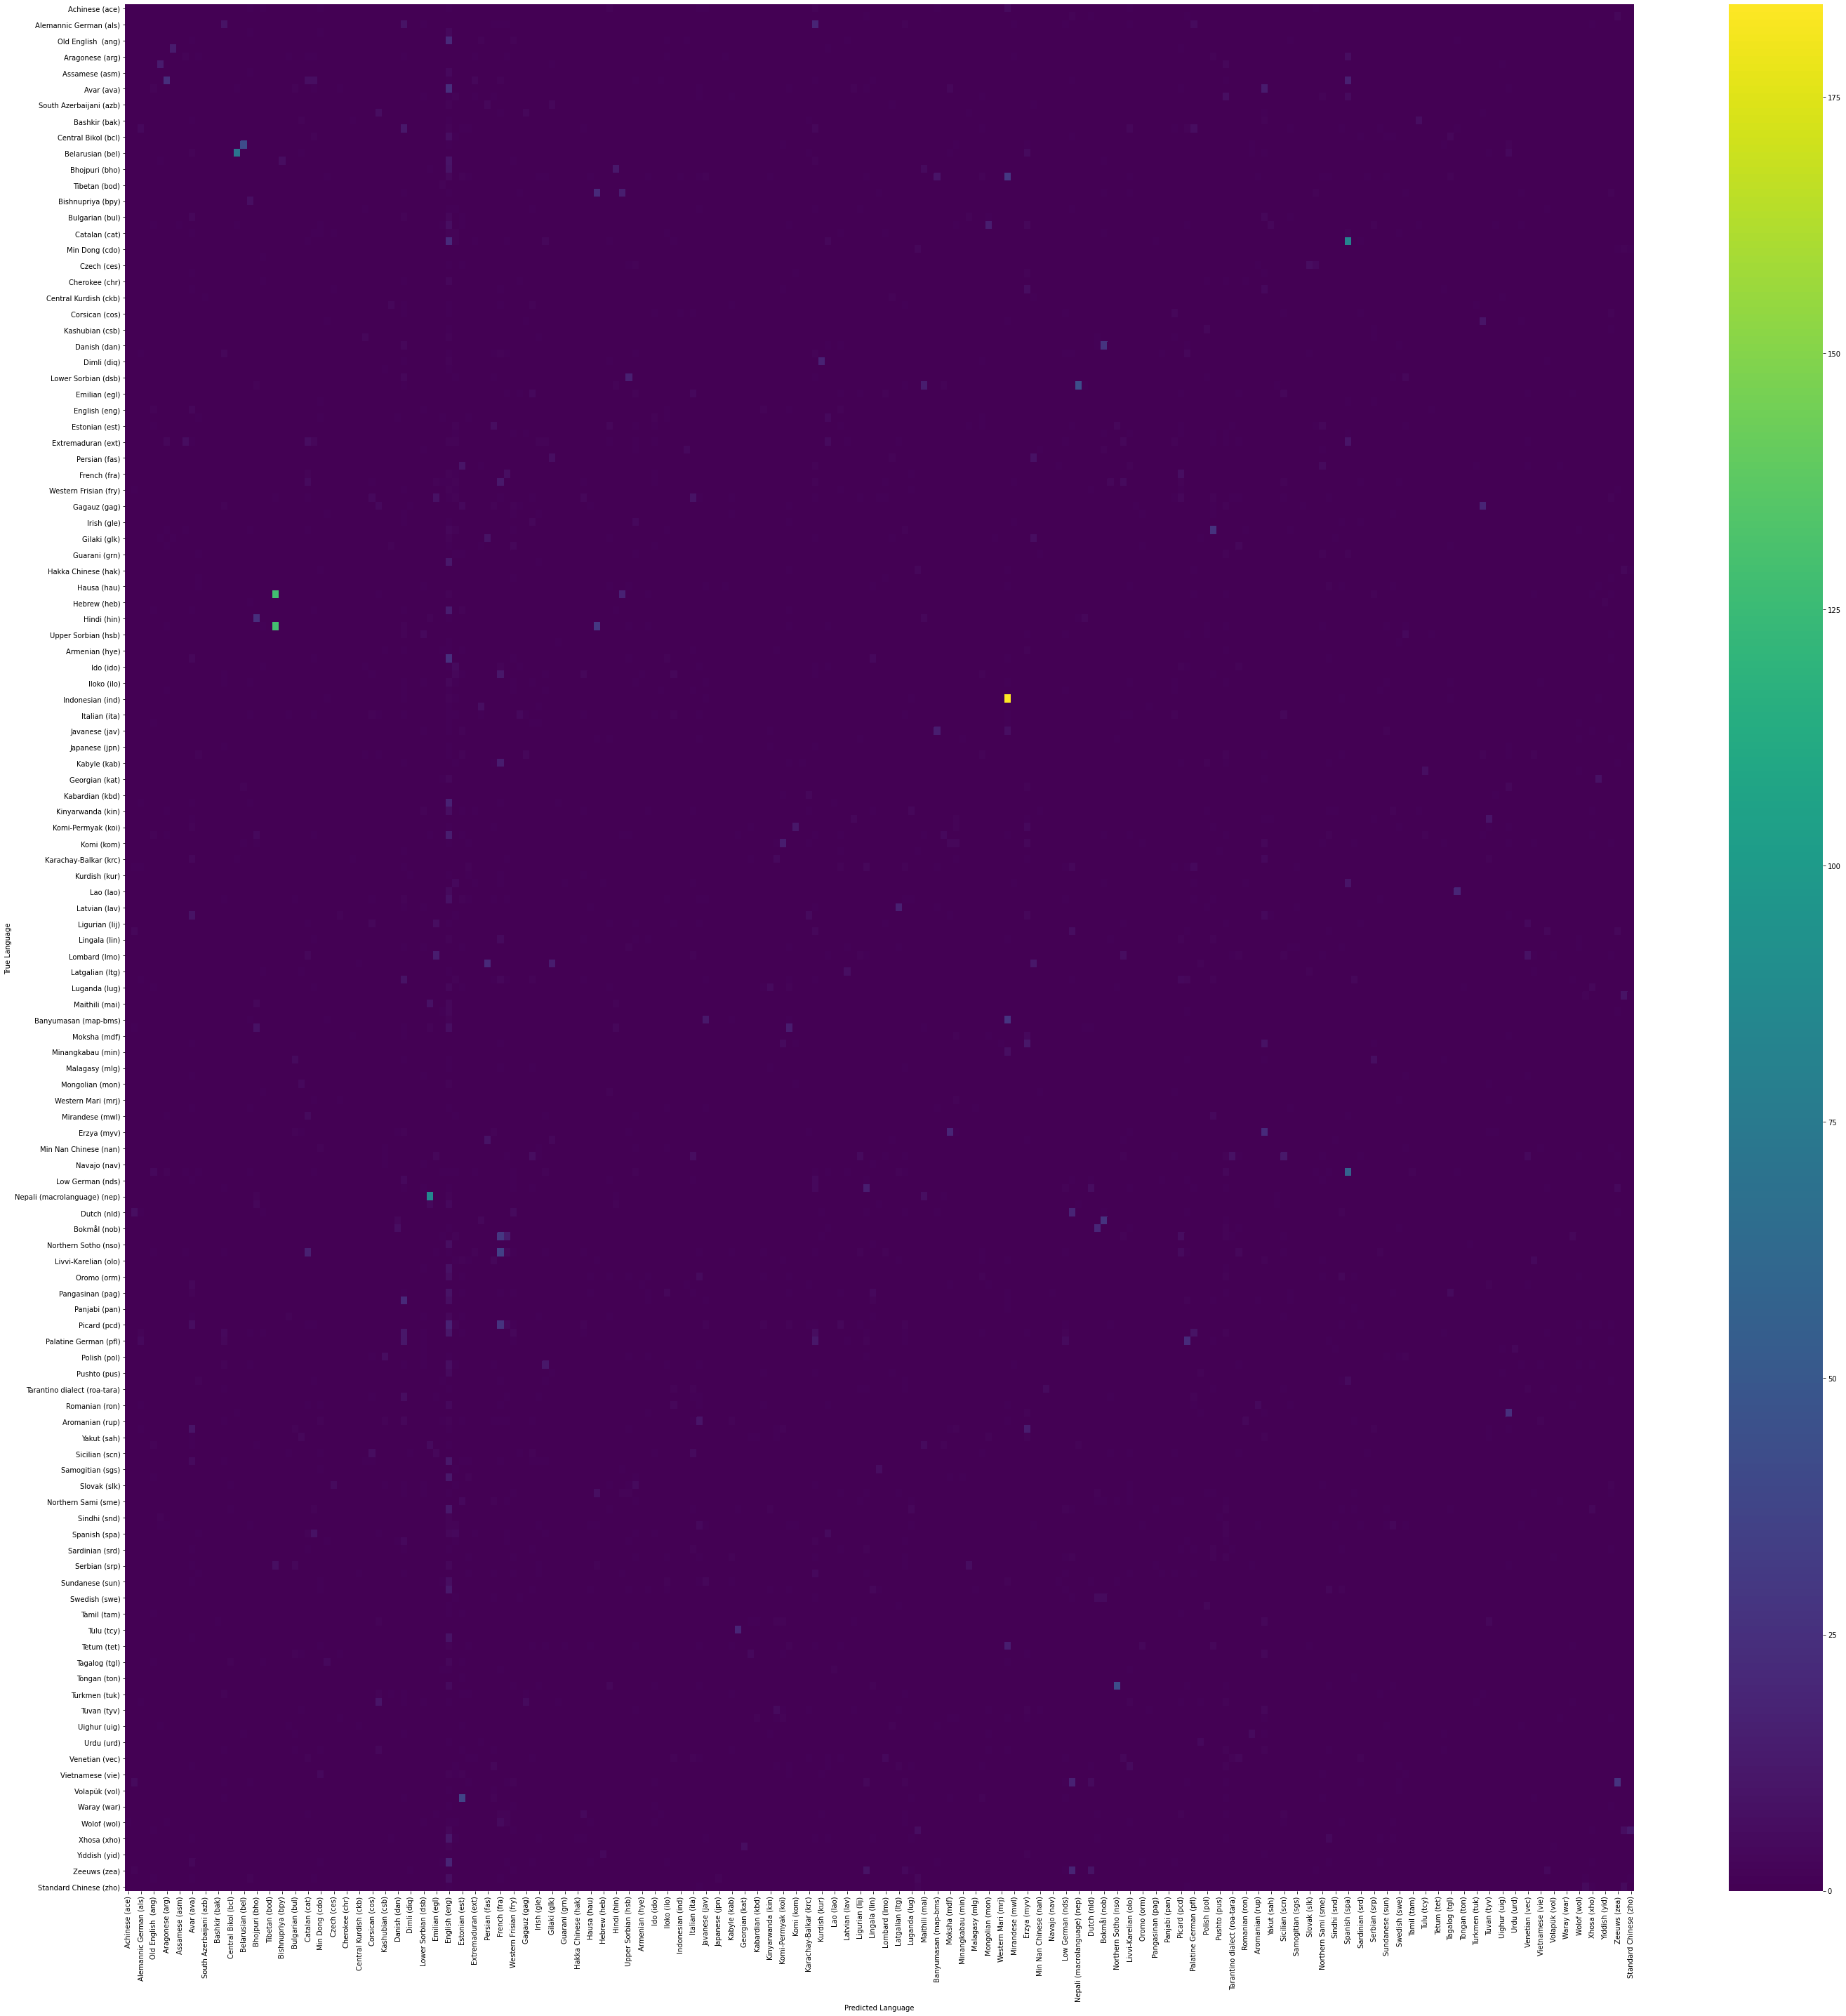

In [131]:
confusion_matrix_plot(y_trues_names, y_preds_names, target_names, cmap="viridis", figsize=(40, 40), diagonal_to_zero=True)